In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Nacitanie iris datasetu
# X - features (data)
# y - triedy (setosa, versicolor, virginica)
# Strukturovany dataset (riadky, stlpce)
iris = load_iris()
X = iris.data
y = iris.target

In [3]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
iris_df.head()

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
# Rozdelenie datasetu na trenovaciu a testovaciu cast (test_size = 0.3 znamena 30% testovacia cast)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
# Vizualizacia datasetu pomocou bodoveho grafu
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Create a scatter plot for each pair of features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

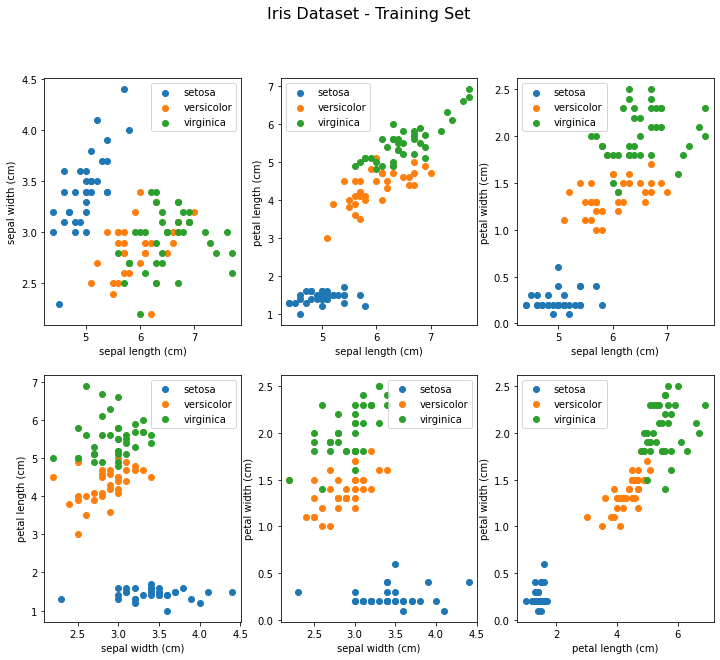

In [6]:
# Vizualizacia trenovacieho setu
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

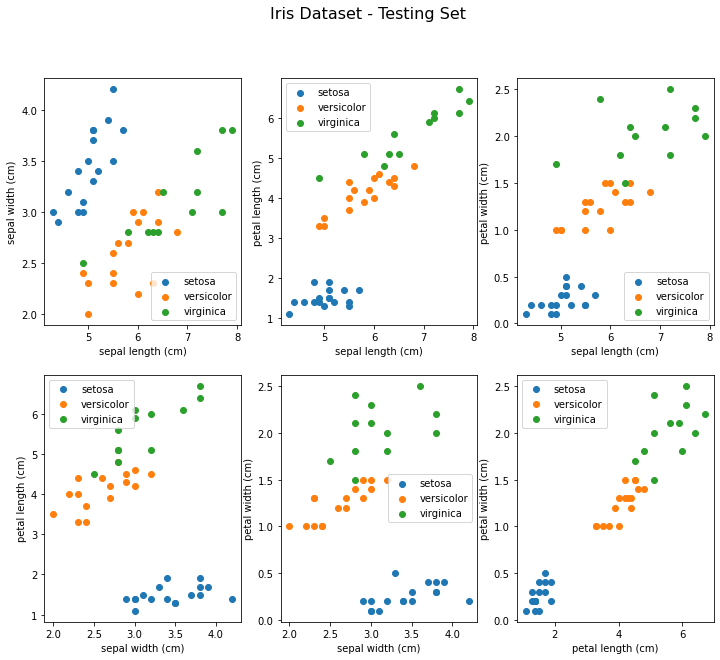

In [7]:
# Vizualizacia testovacieho setu
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [8]:
# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)

[[ 0.53128629  0.86471136  0.99084544  1.5088726 ]
 [-0.60977176 -0.14692867  0.36479156  0.32752661]
 [ 1.29199165  0.35889135  1.04775942  1.37761194]
 [ 1.0384232   0.61180136  1.04775942  1.1150906 ]
 [-1.49726136  0.35889135 -1.2857141  -1.37886204]
 [-1.11690867  1.37053138 -1.39954208 -1.37886204]
 [-0.35620331 -1.41147872  0.02330763 -0.19751605]
 [-0.10263485 -0.9056587   0.13713561 -0.32877671]
 [-1.62404558  0.86471136 -1.39954208 -1.24760137]
 [ 0.27771783 -1.15856871  0.99084544  0.19626595]
 [ 0.53128629 -0.9056587   0.59244752  0.72130861]
 [-0.22941908 -0.39983868  0.1940496   0.06500528]
 [-1.11690867 -0.14692867 -1.2857141  -1.37886204]
 [-1.11690867  0.35889135 -1.51337005 -1.37886204]
 [ 1.16520743 -0.14692867  0.93393145  1.1150906 ]
 [-0.10263485  2.38217142 -1.51337005 -1.37886204]
 [ 0.91163897 -0.14692867  0.30787758  0.19626595]
 [ 1.67234434 -0.14692867  1.10467341  0.45878728]
 [-0.99012444 -1.41147872 -0.48891826 -0.19751605]
 [ 1.0384232  -0.14692867  0.64

In [9]:
# Konvertovanie na tensory
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Vytvorenie dataset objektov
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Vytvorenie loaderov pre loadovanie dat pocas treningu
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
# MLP Model: Likely to perform well given the simplicity and small size of the Iris dataset. MLPs are generally good for tabular data.
# CNN Model: Might be less effective since the Iris dataset is not image data, and CNNs are primarily designed for spatial data. However, with proper adaptation, it can still perform reasonably well.
# RNN Model: RNNs are designed for sequential data, which the Iris dataset is not. Its performance might be less intuitive and could vary depending on how the input data is structured and fed into the model.

In [12]:
# Definovanie MLP Modelu
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        # 4 input features, 8 neuronov
        self.fc1 = nn.Linear(4, 10)
        # Hidden layer - 10 neuronov
        self.fc2 = nn.Linear(10, 10)
        # output layer, 3 output features
        self.fc3 = nn.Linear(10, 3)

    # Metoda pre predikciu
    def forward(self, x):
        x = self.fc1(x)
        # Aplikovanie relu pre hidder layer
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# Definovanie CNN Modelu
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [14]:
# Definovanie RNN Modelu
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 3)

    def forward(self, x):
        x = x.unsqueeze(2)  # Add a feature dimension
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the last time step
        x = self.fc(x)
        return x

In [15]:
# Trenovaci loop, pouziva back propagation
def train(model, criterion, optimizer, epoch_number):
    lossesmean = []
    loss_vall_arr = []
    acc_arr = []
    
    for epoch in range(epoch_number):
        losses = 0
        for data in train_loader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            loss.backward()
            optimizer.step()
        lossesmean.append(losses/len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        
        acc, lossvall = evaluate_model(model, train_loader)
        acc_arr.append(acc)
        loss_vall_arr.append(lossvall)
        
    return lossesmean, loss_vall_arr, acc_arr

In [16]:
# Funkcia pre vyhodnotenie modelu na testovacich datach
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    losses = 0
    lossesmean = []
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses += loss.detach().numpy()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    lossesmean.append(losses/len(train_loader))
    accuracy = 100 * correct / total
    return accuracy, lossesmean

In [17]:
mlp_model = MLPModel()
cnn_model = CNNModel()
rnn_model = RNNModel()

# Definovanie loss funkcie a optimalizatorov
criterion = nn.CrossEntropyLoss()

mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Trenovacie modely
print("MLP")
lossesmean, loss_vall_arr, acc_arr  = train(mlp_model, criterion, mlp_optimizer, 1000)
print("CNN")
train(cnn_model, criterion, cnn_optimizer, 1)
print("RNN")
train(rnn_model, criterion, rnn_optimizer, 1)

# Evaluacia modelov
#mlp_accuracy = evaluate_model(mlp_model, test_loader)
#cnn_accuracy = evaluate_model(cnn_model, test_loader)
#rnn_accuracy = evaluate_model(rnn_model, test_loader)

MLP
Epoch 1, Loss: 0.7155423760414124
Epoch 2, Loss: 1.162406325340271
Epoch 3, Loss: 0.814296305179596
Epoch 4, Loss: 0.9241150617599487
Epoch 5, Loss: 0.39222395420074463
Epoch 6, Loss: 0.377473920583725
Epoch 7, Loss: 0.38234004378318787
Epoch 8, Loss: 0.48537319898605347
Epoch 9, Loss: 0.011543387547135353
Epoch 10, Loss: 0.8142234683036804
Epoch 11, Loss: 0.656446099281311
Epoch 12, Loss: 0.3100535273551941
Epoch 13, Loss: 0.0035387768875807524
Epoch 14, Loss: 0.0031666632276028395
Epoch 15, Loss: 0.0033301631920039654
Epoch 16, Loss: 0.004157234448939562
Epoch 17, Loss: 0.006733110640197992
Epoch 18, Loss: 0.0001560327800689265
Epoch 19, Loss: 0.0013359201839193702
Epoch 20, Loss: 0.0010855264263227582
Epoch 21, Loss: 0.003613610751926899
Epoch 22, Loss: 0.024886909872293472
Epoch 23, Loss: 0.0003748429589904845
Epoch 24, Loss: 0.04282575473189354
Epoch 25, Loss: 6.806619057897478e-05
Epoch 26, Loss: 0.025300778448581696
Epoch 27, Loss: 0.021591367200016975
Epoch 28, Loss: 0.0221

Epoch 235, Loss: 0.0
Epoch 236, Loss: 0.0
Epoch 237, Loss: 0.0
Epoch 238, Loss: 0.0
Epoch 239, Loss: 0.0
Epoch 240, Loss: 2.0265558760002023e-06
Epoch 241, Loss: 3.0636318115284666e-05
Epoch 242, Loss: 0.0
Epoch 243, Loss: 1.1920928244535389e-07
Epoch 244, Loss: 1.1920928244535389e-07
Epoch 245, Loss: 0.00011240804451517761
Epoch 246, Loss: 0.0
Epoch 247, Loss: 1.156323378381785e-05
Epoch 248, Loss: 0.36247774958610535
Epoch 249, Loss: 1.4305104514278355e-06
Epoch 250, Loss: 9.536738616588991e-07
Epoch 251, Loss: 0.0
Epoch 252, Loss: 0.0
Epoch 253, Loss: 0.00011967896716669202
Epoch 254, Loss: 0.0
Epoch 255, Loss: 2.658331868587993e-05
Epoch 256, Loss: 1.1920928244535389e-07
Epoch 257, Loss: 0.02966894954442978
Epoch 258, Loss: 0.0
Epoch 259, Loss: 0.0
Epoch 260, Loss: 0.0
Epoch 261, Loss: 5.006777428206988e-06
Epoch 262, Loss: 0.0
Epoch 263, Loss: 0.0
Epoch 264, Loss: 0.0
Epoch 265, Loss: 0.0
Epoch 266, Loss: 0.6515909433364868
Epoch 267, Loss: 1.1920922133867862e-06
Epoch 268, Loss: 

Epoch 519, Loss: 0.0
Epoch 520, Loss: 0.000325388420606032
Epoch 521, Loss: 5.006777428206988e-06
Epoch 522, Loss: 0.0
Epoch 523, Loss: 2.622600959512056e-06
Epoch 524, Loss: 0.0
Epoch 525, Loss: 0.0
Epoch 526, Loss: 0.0
Epoch 527, Loss: 0.0
Epoch 528, Loss: 0.016920020803809166
Epoch 529, Loss: 0.0
Epoch 530, Loss: 0.0
Epoch 531, Loss: 0.0
Epoch 532, Loss: 5.960462772236497e-07
Epoch 533, Loss: 1.311301275563892e-06
Epoch 534, Loss: 0.00035553809721022844
Epoch 535, Loss: 0.0
Epoch 536, Loss: 0.0
Epoch 537, Loss: 0.0
Epoch 538, Loss: 0.0
Epoch 539, Loss: 3.576278118089249e-07
Epoch 540, Loss: 0.0
Epoch 541, Loss: 0.0
Epoch 542, Loss: 0.0
Epoch 543, Loss: 9.536738616588991e-07
Epoch 544, Loss: 1.2993727978027891e-05
Epoch 545, Loss: 0.0
Epoch 546, Loss: 0.0
Epoch 547, Loss: 0.0
Epoch 548, Loss: 4.768370445162873e-07
Epoch 549, Loss: 0.0
Epoch 550, Loss: 1.7660449743270874
Epoch 551, Loss: 7.152555099310121e-07
Epoch 552, Loss: 0.0
Epoch 553, Loss: 0.0
Epoch 554, Loss: 4.768370445162873

Epoch 819, Loss: 0.0
Epoch 820, Loss: 0.0
Epoch 821, Loss: 0.0
Epoch 822, Loss: 0.0
Epoch 823, Loss: 0.034643929451704025
Epoch 824, Loss: 0.0
Epoch 825, Loss: 0.0
Epoch 826, Loss: 0.0
Epoch 827, Loss: 5.006777428206988e-06
Epoch 828, Loss: 0.0
Epoch 829, Loss: 0.0
Epoch 830, Loss: 0.0065392558462917805
Epoch 831, Loss: 8.380061626667157e-05
Epoch 832, Loss: 0.0
Epoch 833, Loss: 0.00046433156239800155
Epoch 834, Loss: 0.7518799304962158
Epoch 835, Loss: 1.1920928244535389e-07
Epoch 836, Loss: 0.0
Epoch 837, Loss: 0.0
Epoch 838, Loss: 0.0
Epoch 839, Loss: 0.0
Epoch 840, Loss: 0.0
Epoch 841, Loss: 0.0
Epoch 842, Loss: 9.298280929215252e-06
Epoch 843, Loss: 1.4424220353248529e-05
Epoch 844, Loss: 0.0
Epoch 845, Loss: 0.0
Epoch 846, Loss: 1.1920928244535389e-07
Epoch 847, Loss: 0.0
Epoch 848, Loss: 0.0
Epoch 849, Loss: 0.0
Epoch 850, Loss: 0.0
Epoch 851, Loss: 0.0
Epoch 852, Loss: 0.0
Epoch 853, Loss: 0.0
Epoch 854, Loss: 1.1920928244535389e-07
Epoch 855, Loss: 0.13016392290592194
Epoch 85

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


([1.0770075006305047], [[1.062413144786403]], [67.61904761904762])

In [18]:
def classify_samples(model, tensor):
    # Pass the samples through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(new_samples_tensor)
        _, predicted_classes = torch.max(predictions, 1)
    
    # Print the class names
    for i, index in enumerate(predicted_classes):
        print(f"Sample {i+1}: {iris['target_names'][index]}")

In [19]:
print(f'MLP Accuracy: {mlp_accuracy}%')
print(f'CNN Accuracy: {cnn_accuracy}%')
print(f'RNN Accuracy: {rnn_accuracy}%')
print("================================")

# Testuje nové vzorky na MLP modeli, transformuje ich, konvertuje na tenzory, predpovedá triedy a vypisuje názvy predpovedaných tried

new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],
    [6.7, 3.0, 5.2, 2.3],
    [5.9, 3.0, 4.2, 1.5],
    [6.1, 2.9, 4.7, 1.4],
    [4.6, 3.4, 1.4, 0.3]
])

# Scale the samples
new_samples_scaled = scaler.transform(new_samples)

# Konvertovanie na tensor
new_samples_tensor = torch.tensor(new_samples_scaled, dtype=torch.float32)

print("MLP")
classify_samples(mlp_model, new_samples_tensor)
print("CNN")
classify_samples(cnn_model, new_samples_tensor)
print("RNN")
classify_samples(rnn_model, new_samples_tensor)

NameError: name 'mlp_accuracy' is not defined

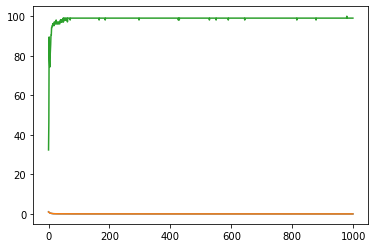

In [20]:
epochs = range(0, 1000)
plt.plot(epochs,lossesmean, label='train')
plt.plot(epochs, loss_vall_arr, label='valid')
plt.plot(epochs,acc_arr, label='acc')

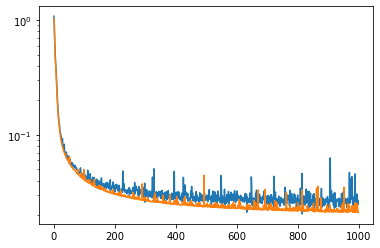

In [21]:
plt.plot(epochs,lossesmean, label='train')
plt.plot(epochs, loss_vall_arr, label='valid')
plt.yscale('log')

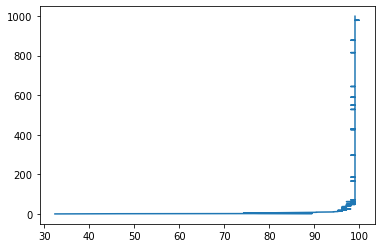

In [22]:
plt.plot(acc_arr, epochs)